### 1. 导入包

In [1]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
import random

2.3.0


### 2. 生成数据集
设训练数据集样本量为1000，特征数为2。给定随机生成的批量样本特征 $X\in\mathcal{R}^{1000\times2}$，使用线性回归模型的真实权重为 $\omega=[2, -3.4]^T$，偏差为 $b=4.2$，以及一个服从均值为0、标准差为0.01的正态分布的随机噪声项 $\epsilon$，来生成标签 $$y=X\omega+b+\epsilon$$
噪声代表了数据集中无意义的干扰。

In [2]:
def synthetic_data(w, b, num_examples):
    X = tf.random.normal([num_examples, len(w)], 0, 1)
    y = tf.matmul(X, w) + b
    y += tf.random.normal(y.shape, mean=0, stddev=0.01)
    return X, y

In [3]:
true_w = tf.constant([2, -3.4], shape=[2,1])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
features.shape

TensorShape([1000, 2])

In [4]:
labels.shape

TensorShape([1000, 1])

In [6]:
print('features:', features[0], '\nlabel:', labels[0])

features: tf.Tensor([ 0.9310991 -0.9638597], shape=(2,), dtype=float32) 
label: tf.Tensor([9.344812], shape=(1,), dtype=float32)


分别生成两个特征和标签的散点图，观察线性关系

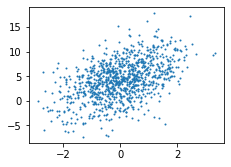

In [9]:
def plot_config(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize

plot_config()
plt.scatter(features[:, 0], labels, 1)

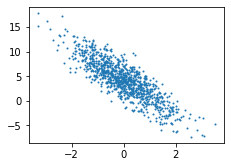

In [10]:
plt.scatter(features[:, 1], labels, 1)

### 3. 读取数据集
小批量随机梯度下降
训练数据集时要对数据集进行遍历，每次抽取一个小批量，用来更新模型参数。
定义一个函数，打乱数据集中的样本，并以小批量方式获取数据。

In [11]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i : min(i+batch_size, num_examples)]
        yield tf.gather(features, axis=0, indices=j), tf.gather(labels, axis=0, indices=j)

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tf.Tensor(
[[ 1.3795706   1.7452172 ]
 [-1.4717827  -1.5257796 ]
 [-0.10258761 -1.709245  ]
 [ 0.17593752  0.7082738 ]
 [-0.6206082  -1.331803  ]
 [ 1.3618513   0.46835485]
 [ 0.5188187   1.1547335 ]
 [ 0.2512547  -1.641773  ]
 [-1.0031388  -1.2994576 ]
 [-2.7303631   0.04354316]], shape=(10, 2), dtype=float32) tf.Tensor(
[[ 1.0226113]
 [ 6.434121 ]
 [ 9.817126 ]
 [ 2.1416318]
 [ 7.498409 ]
 [ 5.32462  ]
 [ 1.3160585]
 [10.286432 ]
 [ 6.6344995]
 [-1.4256414]], shape=(10, 1), dtype=float32)


### 4. 初始化模型参数
将权重初始化为均值为0，标准差为0.01的正态随机数，偏差初始化为0

In [14]:
w = tf.Variable(tf.random.normal([len(true_w), 1], mean=0, stddev=0.01))
b = tf.Variable(tf.zeros((1, )))

In [15]:
w

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.00152149],
       [-0.01127949]], dtype=float32)>

In [16]:
b

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

### 5. 定义模型

In [21]:
def linreg(X, w, b):
    return tf.matmul(X, w) + b

### 6. 定义损失函数

In [22]:
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

### 7. 定义优化算法
`sgd`函数实现小批量随机梯度下降，通过不断迭代模型参数来优化损失函数。
由于自动求梯度模块求得的是一个批量样本的梯度和，将它除以批量的大小得到平均值。

In [23]:
def sgd(params, lr, batch_size, grads):
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)
        # 等价于 param = param - lr * grads[i] / batch_size

`tf.assign()` <br>
`tf.assign_add()` <br>
`tf.assign_sub()` <br>
用法

### 8. 训练模型


In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [28]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as t:
            t.watch([w, b])
            l = tf.reduce_sum(loss(net(X, w, b), y))
        grads = t.gradient(l, [w, b])
        sgd([w, b], lr, batch_size, grads)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' %(epoch+1, tf.reduce_mean(train_l)))

epoch 1, loss 0.042487
epoch 2, loss 0.000169
epoch 3, loss 0.000051


In [31]:
print(w)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9989198],
       [-3.4000285]], dtype=float32)>


In [32]:
print(b)

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.199573], dtype=float32)>


----

:penguin: **`tf.random.normal()`**
```python
tf.random.normal(
    shape,
    mean=0.0,
    stddev=1.0,
    dtype=tf.dtypes.float32,
    seed=None,
    name=None
)
```
Returns:
A tensor of the specified shape filled with random normal values.

----

:penguin: **`tf.constant()`**
```python
tf.constant(
    value, dtype=None, shape=None, name='Const'
)
```
Returns:
A Constant Tensor. 返回一个 Tensor 常量

- 当指定 `shape` 时，`value`值可被 reshape

`tf.constant` will create tensors on the current device. Inputs which are already tensors maintain their placements unchanged.

----

:penguin: `tf.matmul()`
```python
tf.linalg.matmul(
    a,
    b,
    transpose_a=False,
    transpose_b=False,
    adjoint_a=False,
    adjoint_b=False,
    a_is_sparse=False,
    b_is_sparse=False,
    output_type=None,
    name=None
)
```
- 矩阵乘法
- 输入必须在任何转换之后是 rank> = 2 的张量,其中内部 2 维度指定有效的矩阵乘法参数,并且任何其他外部维度匹配。
- 两个相乘矩阵的数据类型必须相同。
- 通过将相应的参数设置为 `Ture`，矩阵可以被转置（transpose）或作共轭变换/共轭转置（adjoint）。
- 如果一个或两个矩阵包含很多的零,则可以通过将相应的 `a_is_sparse` 或 `b_is_sparse` 标志设置为 `True` 来使用更有效的乘法算法。

2维张量矩阵相乘例子

![屏幕截图 2022-04-20 163633](https://note-pics-1305201806.cos.ap-nanjing.myqcloud.com/2022/04/20/163722.png)

A batch matrix multiplication with batch shape [2]

![image-20220420163903661](https://note-pics-1305201806.cos.ap-nanjing.myqcloud.com/2022/04/20/163906.png)
python 版本 >= 3.5, 支持 `@` 运算符，下面两行代码等价
```python
d = a @ b @ [[10], [11]]
d = tf.matmul(tf.matmul(a, b), [[10], [11]])
```

----

:penguin: `python`中的`yield`

`return` 返回函数的所有执行结果

`yield` 返回一个可迭代的生成器对象，可以使用 `for` 循环或调用 `next()` 方法遍历生成器来获得结果。

----

:penguin: `random.shuffle()`

用于将一个列表中的元素打乱。将原列表内元素顺序打乱，不会重新再生成一个列表。

`data_iter` 函数要会写

----

:penguin: `tf.gather` 用法

```python
tf.gather(
    params, indices, axis=None, batch_dims=0, name=None
)
```
|args|meanings|
|:---:|:---:|
|params|The Tensor from which to gather values.|
|indices|The index Tensor. Must be one of the following types: `int32`, `int64`. The values must be in `range([0, params.shape[axis])`|
|axis|A Tensor. Must be one of the following types: `int32`, `int64`. The axis in params to gather indices from. Must be greater than or equal to `batch_dims`. Defaults to the first non-batch dimension. Supports negative indexes.|
|batch_dims|An integer. Must be less than or equal to rank(indices).|
|name|A name for the operation (optional).|

Returns:
A Tensor. Has the same type as params.

`batch_dims` 参数

使用 `batch_dims=1` 相当于在 `params` 和 `indices` 的第一个轴上有一个外循环：
```python
params = tf.constant([
    [0, 0, 1, 0, 2],
    [3, 0, 0, 0, 4],
    [0, 5, 0, 6, 0]])
indices = tf.constant([
    [2, 4],
    [0, 4],
    [1, 3]])
tf.gather(params, indices, axis=1, batch_dims=1).numpy()
# 输出为
>>> array([[1, 2],
           [3, 4],
           [5, 6]], dtype=int32)
# 相当于
def manually_batched_gather(params, indices, axis):
    batch_dims=1
    result = []
    for p,i in zip(params, indices):
        r = tf.gather(p, i, axis=axis-batch_dims)
        result.append(r)
    return tf.stack(result)
manually_batched_gather(params, indices, axis=1).numpy()
# 输出为
>>> array([[1, 2],
           [3, 4],
           [5, 6]], dtype=int32)

In [2]:
import tensorflow as tf

In [3]:
params = tf.constant([
    [0, 0, 1, 0, 2],
    [3, 0, 0, 0, 4],
    [0, 5, 0, 6, 0]])

In [4]:
params.shape

TensorShape([3, 5])

In [5]:
indices = tf.constant([
    [2, 4],
    [0, 4],
    [1, 3]])

In [11]:
a = tf.gather(params, indices, axis=1, batch_dims=0)

In [12]:
a.shape

TensorShape([3, 3, 2])

In [15]:
a.numpy()

array([[[1, 2],
        [0, 2],
        [0, 0]],

       [[0, 4],
        [3, 4],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [5, 6]]])

In [13]:
b = tf.gather(params, indices, axis=1, batch_dims=1)

In [14]:
b.shape

TensorShape([3, 2])

In [16]:
b.numpy()

array([[1, 2],
       [3, 4],
       [5, 6]])

:penguin: `tf.Variable`
```python
tf.Variable(
    initializer,
    name
)
```
一般初始化时使用，`initializer` 是初始化参数，可以有`tf.random_normal`，`tf.constant`，name可选，张量的名字，


:penguin: `tf.reshape`
```python
tf.reshape(
    tensor, shape, name=None
)
```
![image-20220420221631138](https://note-pics-1305201806.cos.ap-nanjing.myqcloud.com/2022/04/20/221633.png)

Returns:
A Tensor. Has the same type as tensor.


:penguin: `tf.GradientTape`